# Cross Validation

In [1]:
import numpy as np
import pandas as pd 

from sklearn.datasets import fetch_california_housing 
from sklearn.model_selection import train_test_split, KFold, LeavePOut, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

## Data

In [2]:
housing = fetch_california_housing()
df = pd.DataFrame(data = housing.data, columns=housing.feature_names)
df["target"] = pd.Series(housing.target)
df.columns = df.columns.str.lower()
df

,medinc,houseage,averooms,avebedrms,population,aveoccup,latitude,longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


## Cross Validation Techniques

### Define Test Set

In [11]:
X = df.drop(columns=["target"])
y = df["target"]

X, X_test, y, y_test = train_test_split(X, y, test_size=0.33) 
X.reset_index(drop = True, inplace = True)
y.reset_index(drop = True, inplace = True)
X.shape, X_test.shape

((13828, 8), (6812, 8))

### Define Preprocessing Model 

In [14]:
pipe = Pipeline([('scaler', StandardScaler()), ('lr', ElasticNet(random_state=666))])

### Define Param Grid

In [15]:
param_grid = {
    "lr__alpha": [0.2, 0.4, 0.8, 1.2, 1.6, 2],
    "lr__l1_ratio": [0.2, 0.4, 0.6, 0.8, 1]
}

### Hyperparameters with Validation Test

In [16]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3) 
print(f'{X_train.shape = }')
print(f'{X_test.shape = }')
print(f'{X_validation.shape = }')

X_train.shape = (9679, 8)
X_test.shape = (6812, 8)
X_validation.shape = (4149, 8)


In [17]:
grid = ParameterGrid(param_grid)

train_results = []
validation_results = []

for p in grid:
    # Set the Model
    model = pipe 
    model.set_params(**p)

    # Train and Predict 
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_validation_pred = model.predict(X_validation)

    # Save the results 
    train_results.append(mean_squared_error(y_train, y_train_pred))
    validation_results.append(mean_squared_error(y_validation, y_validation_pred))

In [18]:
results = pd.DataFrame()
results["params"] = list(grid)
results["train_results"] = train_results 
results["validation_results"] = validation_results
results["overfitting"] = results["validation_results"] - results["train_results"]
results.sort_values(by = ["validation_results", "overfitting"], ascending=True, inplace = True)
results.head(10)

,params,train_results,validation_results,overfitting
0,"{'lr__alpha': 0.2, 'lr__l1_ratio': 0.2}",0.645440,0.626391,-0.019050
1,"{'lr__alpha': 0.2, 'lr__l1_ratio': 0.4}",0.685834,0.664459,-0.021374
2,"{'lr__alpha': 0.2, 'lr__l1_ratio': 0.6}",0.704987,0.683325,-0.021663
3,"{'lr__alpha': 0.2, 'lr__l1_ratio': 0.8}",0.722586,0.702137,-0.020448
5,"{'lr__alpha': 0.4, 'lr__l1_ratio': 0.2}",0.731279,0.712428,-0.018850
4,"{'lr__alpha': 0.2, 'lr__l1_ratio': 1}",0.739140,0.719694,-0.019445
6,"{'lr__alpha': 0.4, 'lr__l1_ratio': 0.4}",0.773517,0.755181,-0.018335
7,"{'lr__alpha': 0.4, 'lr__l1_ratio': 0.6}",0.798817,0.781343,-0.017474
8,"{'lr__alpha': 0.4, 'lr__l1_ratio': 0.8}",0.824978,0.808130,-0.016848
9,"{'lr__alpha': 0.4, 'lr__l1_ratio': 1}",0.859140,0.842993,-0.016147


In [19]:
best_params = results.params.values[0]
print(f'{best_params = }')

# Test Set 
model = pipe 
model.set_params(**best_params)

# Test Set 
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Save the results 
print(f'{mean_squared_error(y_train, y_train_pred) = }')
print(f'{mean_squared_error(y_test, y_test_pred) = }')

best_params = {'lr__alpha': 0.2, 'lr__l1_ratio': 0.2}
mean_squared_error(y_train, y_train_pred) = 0.645440413583677
mean_squared_error(y_test, y_test_pred) = 0.6636413488696029


### Hyperparameters with CV 

In [27]:
kf = KFold(n_splits=5)

mean_train_error_results = []
mean_validation_error_results = []

for p in grid:
    # Set the Model
    model = pipe 
    model.set_params(**p)

    train_results = []
    validation_results = []

    # Train and Predict 
    for train_index, validation_index in kf.split(X):
        # Split 
        X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        # Fit 
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_validation_pred = model.predict(X_validation)

        # Save the results 
        train_results.append(mean_squared_error(y_train, y_train_pred))
        validation_results.append(mean_squared_error(y_validation, y_validation_pred))

    mean_train_error_results.append(np.array(train_results).mean())
    mean_validation_error_results.append(np.array(validation_results).mean())

In [28]:
results = pd.DataFrame()
results["params"] = list(grid)
results["train_results"] = mean_train_error_results 
results["validation_results"] = mean_validation_error_results
results["overfitting"] = results["validation_results"] - results["train_results"]
results.sort_values(by = ["validation_results", "overfitting"], ascending=True, inplace = True)
results.head(10)

,params,train_results,validation_results,overfitting
0,"{'lr__alpha': 0.2, 'lr__l1_ratio': 0.2}",0.639639,0.640243,0.000604
1,"{'lr__alpha': 0.2, 'lr__l1_ratio': 0.4}",0.678636,0.679003,0.000367
2,"{'lr__alpha': 0.2, 'lr__l1_ratio': 0.6}",0.696701,0.697044,0.000343
3,"{'lr__alpha': 0.2, 'lr__l1_ratio': 0.8}",0.714333,0.714683,0.000350
5,"{'lr__alpha': 0.4, 'lr__l1_ratio': 0.2}",0.724513,0.724823,0.000310
4,"{'lr__alpha': 0.2, 'lr__l1_ratio': 1}",0.732128,0.732366,0.000238
6,"{'lr__alpha': 0.4, 'lr__l1_ratio': 0.4}",0.765886,0.766188,0.000302
7,"{'lr__alpha': 0.4, 'lr__l1_ratio': 0.6}",0.792005,0.792219,0.000214
8,"{'lr__alpha': 0.4, 'lr__l1_ratio': 0.8}",0.818087,0.818327,0.000240
9,"{'lr__alpha': 0.4, 'lr__l1_ratio': 1}",0.852128,0.852402,0.000274


In [29]:
best_params = results.params.values[0]
print(f'{best_params = }')

best_params = {'lr__alpha': 0.2, 'lr__l1_ratio': 0.2}


### Leave one Out

In [55]:
lp = LeavePOut(1)

mean_train_error_results = []
mean_validation_error_results = []

for p in grid:
    # Set the Model
    model = pipe 
    model.set_params(**p)

    train_results = []
    validation_results = []

    # Train and Predict 
    for train_index, validation_index in lp.split(X[0:100]):
        # Split 
        X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        # Fit 
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_validation_pred = model.predict(X_validation)

        # Save the results 
        train_results.append(mean_squared_error(y_train, y_train_pred))
        validation_results.append(mean_squared_error(y_validation, y_validation_pred))

    mean_train_error_results.append(np.array(train_results).mean())
    mean_validation_error_results.append(np.array(validation_results).mean())

In [56]:
results = pd.DataFrame()
results["params"] = list(grid)
results["train_results"] = mean_train_error_results 
results["validation_results"] = mean_validation_error_results
results["overfitting"] = results["validation_results"] - results["train_results"]
results.sort_values(by = ["validation_results", "overfitting"], ascending=True, inplace = True)
results.head(10)

,params,train_results,validation_results,overfitting
0,"{'lr__alpha': 0.2, 'lr__l1_ratio': 0.2}",0.788256,1.097869,0.309613


# Time Series Cross Validation

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

from warnings import simplefilter
from statsmodels.tools.sm_exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## Data

In [3]:
def read_dataset():

    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url)
    df["date"] = pd.to_datetime(df["Month"], format = "%Y-%m")
    df.drop(columns=["Month"], inplace = True)
    df.sort_values(by = ["date"], ascending=True, inplace = True)
    df.reset_index(drop = True, inplace = True)

    return df 

df = read_dataset()
X = df["Passengers"]
df

,Passengers,date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01
...,...,...
139,606,1960-08-01
140,508,1960-09-01
141,461,1960-10-01
142,390,1960-11-01


In [4]:
param_grid = {
    "p": [6, 8, 10, 12, 13],
    "d": [1, 2],
    "q": [6, 8, 10, 12, 13],
}

grid = ParameterGrid(param_grid) 

In [5]:
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=12)

train_results = []
test_results = []

for g in grid:
    # Set the Model

    train_results_split = []
    test_results_split = []

    # Train and Predict 
    for train_index, test_index in tscv.split(X):
        # Split 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        
        try:
            # Fit 
            model = ARIMA(X_train, order=(g["p"],g["d"],g["q"]))
            model_fit = model.fit()

            train_predict = model_fit.predict(start=0, end=len(X_train)-1)
            test_predict = model_fit.forecast(steps = len(X_test))

            mse_train = mean_squared_error(X_train, train_predict)
            mse_test = mean_squared_error(X_test, test_predict)

            # Save the results 
            train_results_split.append(mse_train)
            test_results_split.append(mse_test)
        except: 
            # Save the results 
            train_results_split.append(None)
            test_results_split.append(None)

    train_results.append(np.array(train_results_split).mean())
    test_results.append(np.array(test_results_split).mean())

/Users/nelson.moreno/anaconda3/envs/data-science/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/nelson.moreno/anaconda3/envs/data-science/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/nelson.moreno/anaconda3/envs/data-science/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/nelson.moreno/anaconda3/envs/data-science/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as sta

In [6]:
results = pd.DataFrame()
results["params"] = list(grid)
results["train_results"] = train_results 
results["test_results"] = test_results
results["overfitting"] = results["test_results"] - results["train_results"]
results.sort_values(by = ["test_results", "overfitting"], ascending=True, inplace = True)
results.head(10)

,params,train_results,test_results,overfitting
37,"{'d': 2, 'p': 10, 'q': 10}",224.210598,576.642928,352.432330
41,"{'d': 2, 'p': 12, 'q': 8}",229.313054,640.215016,410.901962
39,"{'d': 2, 'p': 10, 'q': 13}",249.958421,666.223070,416.264650
42,"{'d': 2, 'p': 12, 'q': 10}",226.889101,717.132809,490.243708
40,"{'d': 2, 'p': 12, 'q': 6}",226.567908,758.339408,531.771500
22,"{'d': 1, 'p': 13, 'q': 10}",194.307878,863.829121,669.521242
6,"{'d': 1, 'p': 8, 'q': 8}",301.888885,887.039726,585.150841
17,"{'d': 1, 'p': 12, 'q': 10}",197.108876,925.139047,728.030171
18,"{'d': 1, 'p': 12, 'q': 12}",194.664822,939.428159,744.763337
8,"{'d': 1, 'p': 8, 'q': 12}",254.711027,949.375104,694.664077


In [7]:
best_params = results.params.values[0]
print(f'{best_params = }')

best_params = {'d': 2, 'p': 10, 'q': 10}


/Users/nelson.moreno/anaconda3/envs/data-science/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nelson.moreno/anaconda3/envs/data-science/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


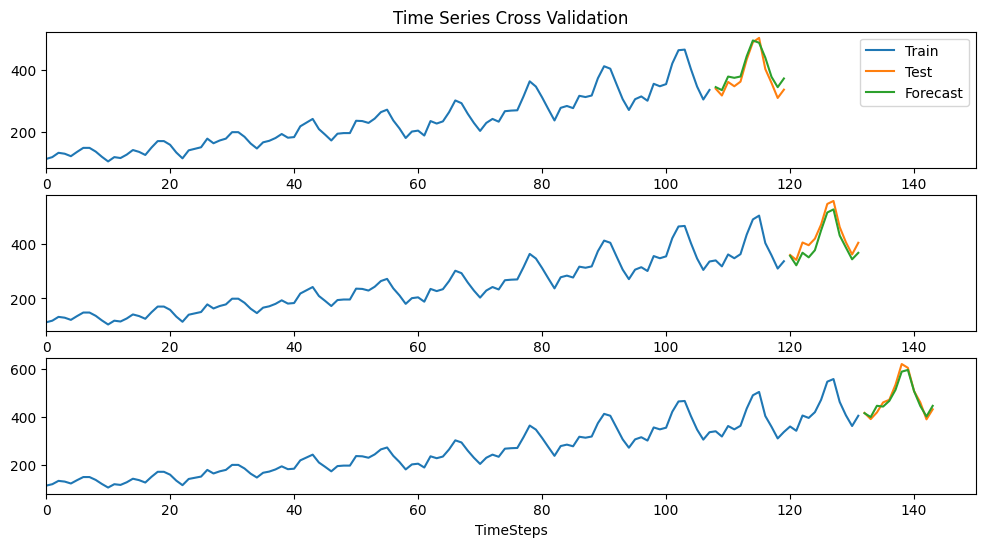

In [20]:
fig, axs = plt.subplots(3, figsize=(12,6))

for i, (train_index, test_index) in enumerate(tscv.split(X)):

    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]

    model = ARIMA(X_train, order=(best_params["p"],best_params["d"],best_params["q"]))
    model_fit = model.fit()

    test_predict = model_fit.forecast(steps = len(X_test))

    axs[i].plot(train_index, X_train, label = "Train")
    axs[i].plot(test_index, X_test, label = "Test")
    axs[i].plot(test_index, test_predict, label = "Forecast")
    axs[i].set_xlabel("TimeSteps")
    axs[i].set_xlim(0, 150)
    
axs[0].legend()
axs[0].set_title("Time Series Cross Validation")
plt.savefig("img/time_series_cross_validation.png", dpi = 300, bbox_inches='tight')
plt.show()
